In [1]:
import scipy.io
import scipy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from tensorflow.keras.utils import plot_model

In [2]:
from comsolml import read_data
from comsolml.filter import butter_lowpass_filter
from comsolml.custom_fk import tx_fk_plot, make_fk
from comsolml.custom_ml import make_regression_model, make_autoencoder, do_regression, plot_reg_results

In [3]:
timesamples = 400
noisedb = -18
dt = 1e-6
numsensors = 8
dx = 3456*0.2/numsensors

In [4]:
read_data

<module 'comsolml.read_data' from 'c:\\Users\\Magnus\\PycharmProjects\\PhD\\Comsol_ML\\notebooks\\comsolml\\read_data.py'>

# COMSOL Data

In [5]:
filename_synth = Path().joinpath('..', 'data', 'input_synth', 'concat_traces_systematic_f80_145.mat')
X = read_data.read_synth(filename_synth, 'concat_traces', 9, 18, geom_spread=False)

In [6]:
X.shape

(3341, 8, 401)

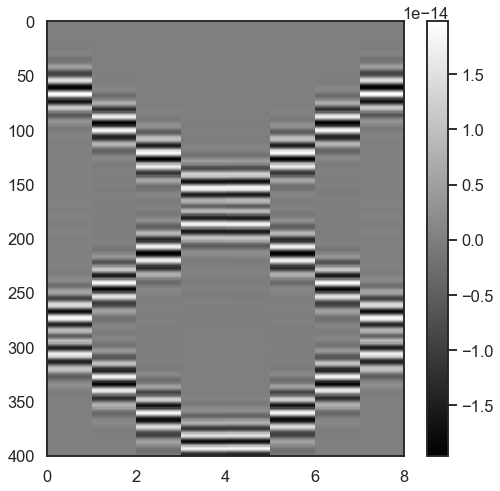

In [7]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [8]:
labels = pd.read_csv(Path().joinpath('..', 'data', 'input_synth', 'labels_systematic_f80_145.csv'))

In [9]:
labels.rename(columns={'thickness':'Thickness',
                       'depression':'Depression depth',
                       'pitting':'Pitting depth',
                       'depression_mu':'Depression location',
                       'depression_sigma':'Depression width',
                       'thickness_max':'Thickness maximum',
                       'thickness_min':'Thickness minimum',
                       'thickness_mean':'Thickness mean',
                       'thickness_median':'Thickness median',
                       'thickness_std':'Thickness std'}, inplace=True)

In [10]:
'''
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pcolormesh(X_sample_c[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(X_sample_n[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()
'''

"\nsns.set_style('white')\nsns.set_context('talk')\nplt.figure(figsize=(12,8))\nplt.subplot(1,2,1)\nplt.pcolormesh(X_sample_c[0,:,:].T, cmap='gray')\nplt.gca().invert_yaxis()\nplt.colorbar()\nplt.subplot(1,2,2)\nplt.pcolormesh(X_sample_n[0,:,:].T, cmap='gray')\nplt.gca().invert_yaxis()\nplt.colorbar()\n\n\nplt.show()\n"

# Verasonics Data

In [11]:
#pathname_data = Path().joinpath('..','data', 'input_real', 'Verasonics_data', 'magnus_2023_03_09', 'data')
pathname_data = Path().joinpath('..','data', 'input_real', 'Verasonics_data', 'magnus_2023_03_14', 'data')

In [12]:
#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_inputfilterfix_2023-03-03_15_15_55.mat')
#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_inputfilterfix_2023-03-09_15_57_15.mat')

#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_2023-03-14_13_22_20.mat') #strap off
#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_2023-03-14_13_26_56.mat') #strap on
filename_data = Path().joinpath(pathname_data, '080kHz_8ch_s1_2023-03-14_13_30_15.mat')
#filename_data = Path().joinpath(pathname_data, '100kHz_8ch_s1_2023-03-14_13_31_21.mat')
#filename_data = Path().joinpath(pathname_data, '120kHz_8ch_s1_2023-03-14_13_32_29.mat')

In [13]:
mat = scipy.io.loadmat(filename_data)

In [14]:
meta = mat['meta']
t_array = meta['FTaxis'][0,0]
data = mat['RFdata']

In [15]:
data = data[:,1:,:] #Remove source trace

In [16]:
np.diff(t_array).min()/1e-6

0.7999999999995858

Sample rate is 0.8 microseconds (1.25Mhz)

In [17]:
native_dt = 0.8e-6

In [18]:
data_stack = np.sum(data, axis=2)

In [19]:
def remove_dc(data):
    return data - data.mean(axis=0, keepdims=True)

In [20]:
data_stack_dc_removed = remove_dc(data_stack)

In [21]:
def compute_rms(trace):
    squared = np.float64(np.square(trace))
    mean = np.sum(squared)/len(trace)
    rms = np.sqrt(mean)
    return rms

In [22]:
def compute_rms_values(data):
    rms_values = []
    trace_nums = np.arange(0, data.shape[1])
    for trace_num in trace_nums:
        rms_values.append(compute_rms(data[:,trace_num]))
    return rms_values

In [23]:
rms_values = compute_rms_values(data_stack_dc_removed[:,:])

In [24]:
scaling_factors = [1/x for x in rms_values]

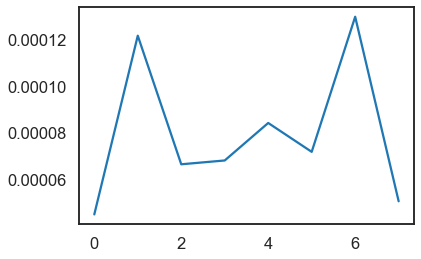

In [25]:
plt.plot(scaling_factors)

In [26]:
data_stack_scaled = np.zeros(shape=data_stack_dc_removed.shape)
for trace_num, scaling_factor in enumerate(scaling_factors):
    data_stack_scaled[:,trace_num] = scaling_factor*data_stack_dc_removed[:,trace_num]

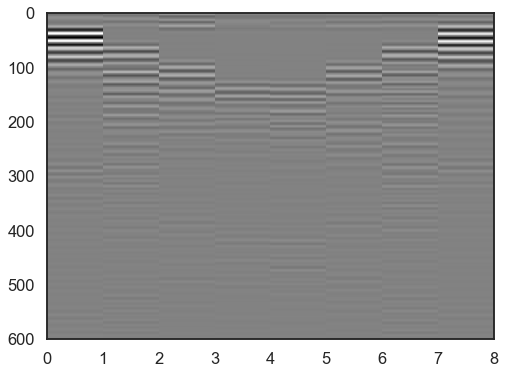

In [27]:
plt.figure(figsize=(8,6))
plt.pcolormesh(data_stack_scaled[:600,:], cmap='gray')
plt.gca().invert_yaxis()
plt.show()

In [28]:
#data_stack_scaled.shape, X_sample_n.shape

In [93]:
# Crop and Resample
data_stack_scaled_resamp = scipy.signal.resample(data_stack_scaled[:600,:], 480).T

In [94]:
data_stack_scaled_resamp.shape

(8, 480)

In [95]:
data_stack_scaled_resamp = data_stack_scaled_resamp/data_stack_scaled_resamp.max()

In [96]:
data_stack_scaled_resamp.min()

-1.0466993661503212

In [32]:
labels[(labels['Thickness'] == 6.8)]

,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var,model_rough_coeff,num_pits
42,model_s101_t034_d000_p000,6.8,101,0.0,0.0,351.267366,55.653407,6.8,6.8,6.800000,6.8,0.000000,0.000000,1.000000,0
43,model_s101_t034_d000_p002,6.8,101,0.0,0.4,351.267366,55.653407,6.8,6.4,6.603877,6.6,0.145226,0.021091,1.271427,0
44,model_s101_t034_d000_p004,6.8,101,0.0,0.8,351.267366,55.653407,6.8,6.0,6.469792,6.4,0.234485,0.054983,1.314587,228
45,model_s101_t034_d000_p006,6.8,101,0.0,1.2,351.267366,55.653407,6.8,5.6,6.414352,6.4,0.289402,0.083753,1.322979,85
46,model_s101_t034_d000_p008,6.8,101,0.0,1.6,351.267366,55.653407,6.8,5.2,6.399595,6.4,0.310864,0.096637,1.324897,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3210,model_s116_t034_d024_p002,6.8,116,4.8,0.4,302.458280,37.896593,6.8,1.6,5.943345,6.6,1.359942,1.849443,1.274064,0
3211,model_s116_t034_d024_p004,6.8,116,4.8,0.8,302.458280,37.896593,6.8,1.2,5.813947,6.4,1.368364,1.872419,1.312067,178
3212,model_s116_t034_d024_p006,6.8,116,4.8,1.2,302.458280,37.896593,6.8,1.0,5.745023,6.2,1.380354,1.905376,1.324056,88
3213,model_s116_t034_d024_p008,6.8,116,4.8,1.6,302.458280,37.896593,6.8,1.0,5.713773,6.2,1.388619,1.928262,1.324535,33


In [33]:
from acoustics import generator
def make_noise(noisedb, noiseshape, color='whitenormal'):
  noiselev = 10**(noisedb/10)
  if color=='whitenormal':
    noise = np.random.normal(loc=0, scale=1, size=noiseshape)*noiselev
  else:
    noise = np.zeros(noiseshape, dtype='float32')
    for i in range(noiseshape[0]):
      for j in range(noiseshape[1]):
        noise[i, j, :] = generator.noise(noiseshape[2], color='white')*noiselev
  return noise

In [54]:
X.max()

4.4753108e-14

In [34]:
#X_crop = X[:,:,26:]

In [62]:
#time_scaling = np.cbrt(np.arange(1, X.shape[-1]+1, dtype='float32'))
time_scaling = np.sqrt(np.arange(1, X.shape[-1]+1, dtype='float32'))
time_scaling = np.expand_dims(time_scaling, -1).T
time_scaling.shape

(1, 401)

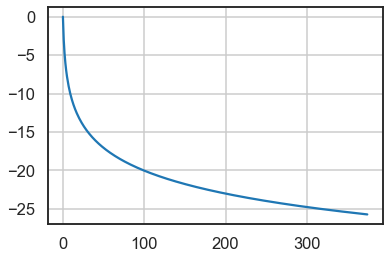

In [36]:
plt.plot(20*np.log10(1/time_scaling[0]))
plt.grid()
plt.show()

In [63]:
X.shape

(3341, 8, 401)

In [84]:
X_geom = np.divide(X, time_scaling**3)

In [85]:
X_sample_c = X_geom/X_geom.max()

In [86]:
X_sample_n = X_sample_c + make_noise(noisedb, X_sample_c.shape)

In [87]:
X_sample_n.max()

0.9862311749229897

In [97]:
data_stack_scaled_resamp_n = data_stack_scaled_resamp + make_noise(noisedb, data_stack_scaled_resamp.shape)

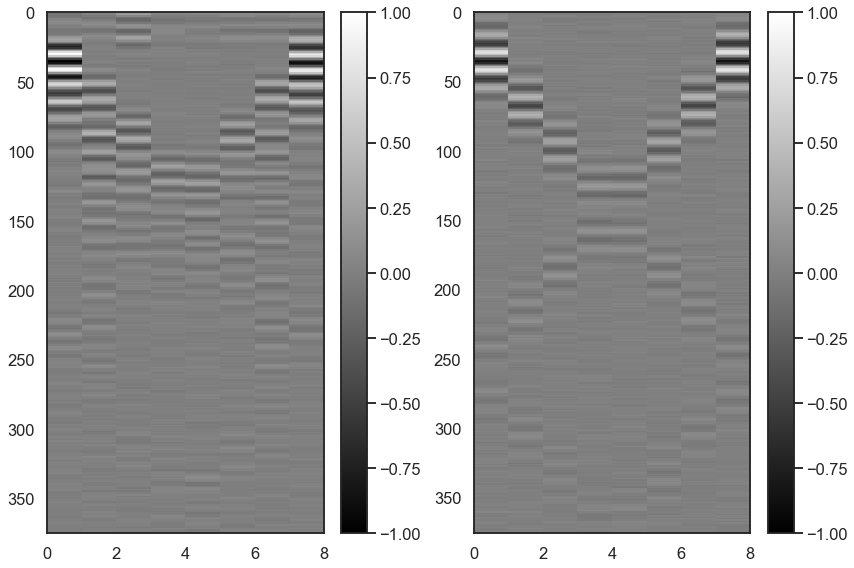

In [100]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.pcolormesh(data_stack_scaled_resamp_n[:,:375].T, cmap='gray')
plt.gca().invert_yaxis()
plt.clim(-1, 1)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(X_sample_n[42,:,25:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.clim(-1,1)
plt.colorbar()
plt.tight_layout()

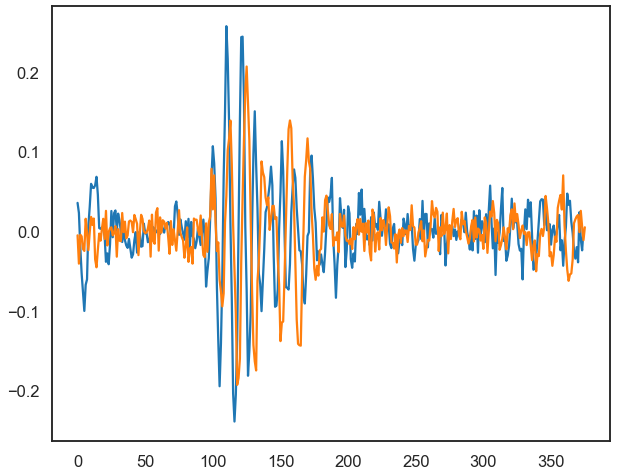

In [103]:
plt.figure(figsize=(10,8))
plt.plot(data_stack_scaled_resamp_n[3,:375])
plt.plot(X_sample_n[42,3,25:])
plt.show()

In [117]:
X_sample_n = X_sample_n[:,:,26:]

In [106]:
verasonics_data = data_stack_scaled_resamp_n[:,:375]

In [107]:
verasonics_data.shape

(8, 375)

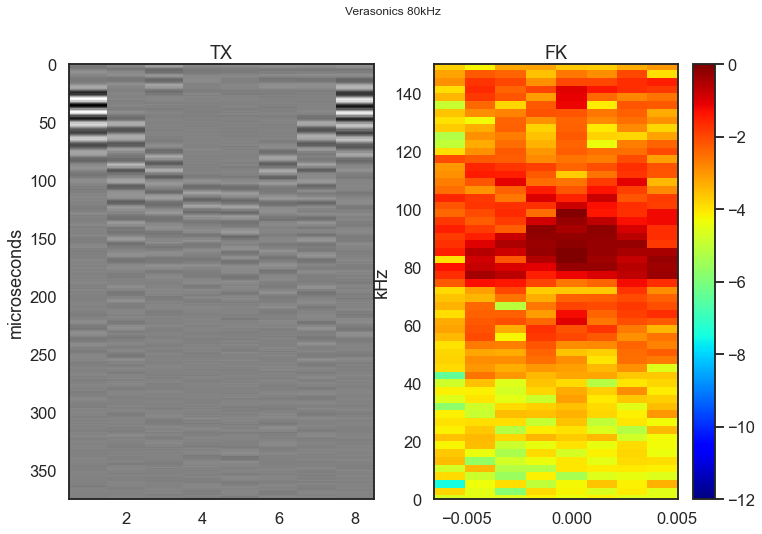

In [120]:
tx_fk_plot(verasonics_data.T, dt, dx, title='Verasonics 80kHz')

In [118]:
X_sample_n.shape

(3341, 8, 375)

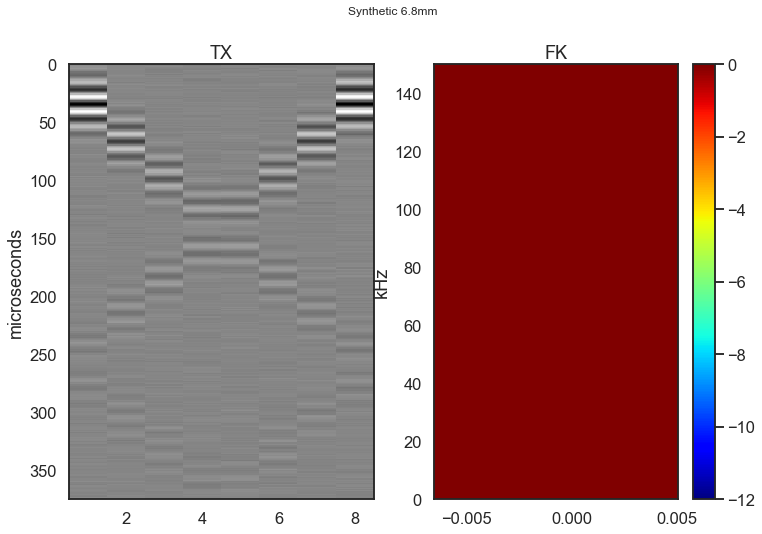

In [122]:
tx_fk_plot(X_sample_n[42,:,:].T, dt, dx, title='Synthetic 6.8mm', log=False)